# Chapter 13

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

In [2]:
plt.rcParams["figure.figsize"] = [14, 7] 

<Axes: title={'center': 'Monthly Energy Consumption'}, xlabel='Month'>

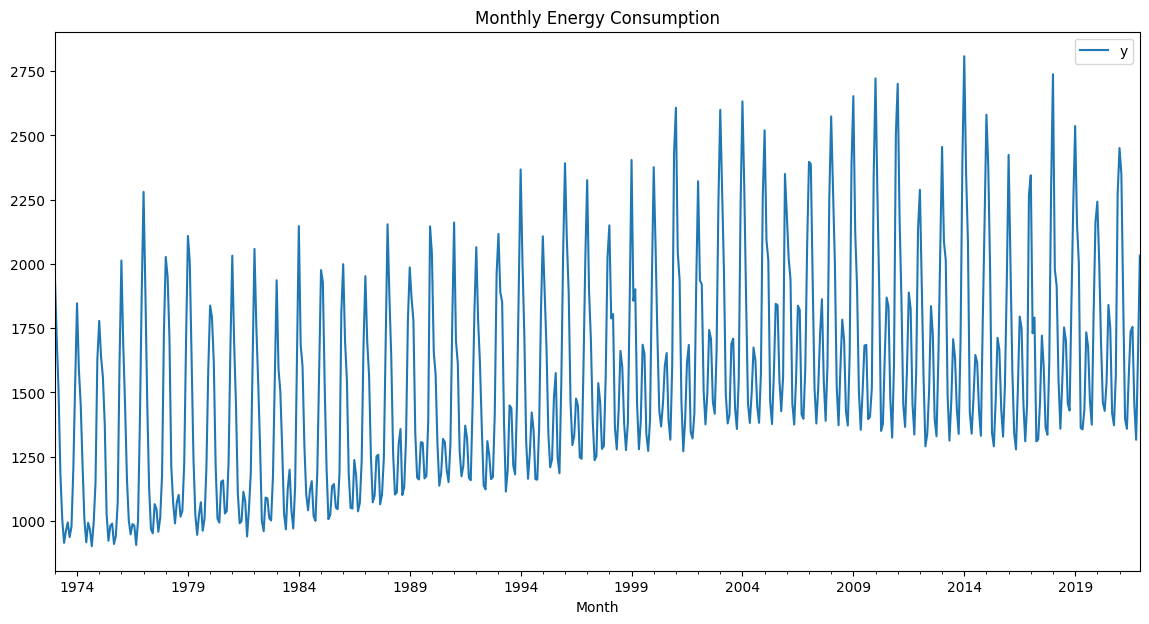

In [3]:
warnings.filterwarnings('ignore')
path = Path('../../datasets/Ch13/')
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)

energy.columns = ['y']
energy.index.freq = 'MS'
energy.plot(title='Monthly Energy Consumption')


In [4]:
en_cp = energy.copy()
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

def sequence_data_preparation(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test


class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [5]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [6]:
en_df = sequence_data_preparation(en_cp, 10)

print(en_df.shape)

scale_en = Standardize(en_df)
train_en, test_en, val_en = scale_en.fit_transform()

print(f'''
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')

(578, 11)

energy: train: 469 , test: 57, val: 52



In [13]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_ts(train_en, 
                             val_en, 
                             test_en)

## Using LSTM (Keras)

In [16]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model
    
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history
    
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    predicted = scale_en.inverse_y(predicted)
    x_test = scale_en.inverse_y(x_test)
    y_test = scale_en.inverse_y(y_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

In [17]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_en_lstm = train_model_ts(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9658 - mean_absolute_error: 0.8501 - root_mean_squared_error: 0.9819 - val_loss: 1.2794 - val_mean_absolute_error: 0.8364 - val_root_mean_squared_error: 1.1311
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9045 - mean_absolute_error: 0.8245 - root_mean_squared_error: 0.9503 - val_loss: 1.2464 - val_mean_absolute_error: 0.8308 - val_root_mean_squared_error: 1.1164
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8820 - mean_absolute_error: 0.8131 - root_mean_squared_error: 0.9384 - val_loss: 1.2134 - val_mean_absolute_error: 0.8254 - val_root_mean_squared_error: 1.1015
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8678 - mean_absolute_error: 0.8052 - root_mean_squared_error: 0.9309 - val_loss: 1.1833 - val_mean_absolute_error: 0.8195 - val_root_mean_squared_error: 1.0878
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8390 - mean_absolute_error: 0.7928 - root_mean_squared_error: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


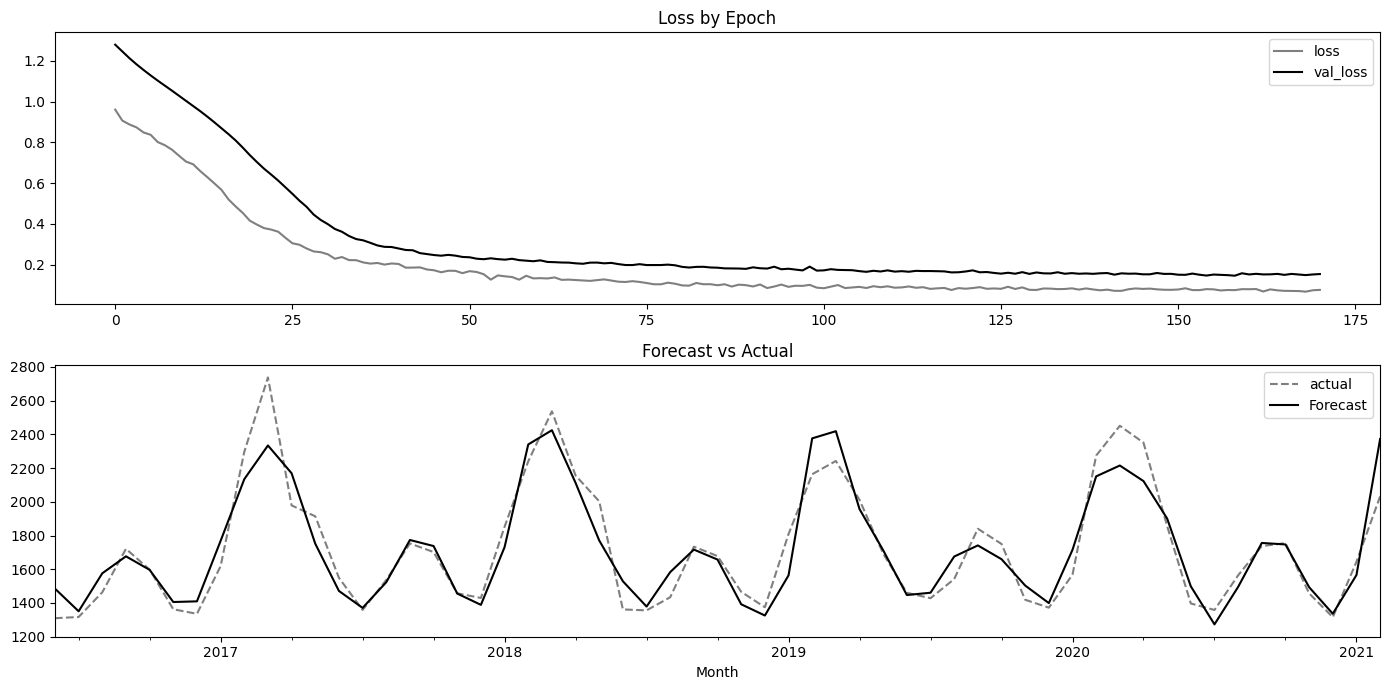

In [21]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## Using LSTM (PyTorch)

In [24]:
# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [25]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

In [27]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

In [28]:
train_en, test_en, val_en = scale_en.fit_transform()

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_pt(train_en, 
                             val_en, 
                             test_en)

0/500 - Loss:  1.0463802814483643, val_loss: 1.3041216135025024
20/500 - Loss:  0.13258041441440582, val_loss: 0.21712413430213928
40/500 - Loss:  0.08143281936645508, val_loss: 0.16626641154289246
60/500 - Loss:  0.07386856526136398, val_loss: 0.15389880537986755
80/500 - Loss:  0.06559382379055023, val_loss: 0.14706484973430634
100/500 - Loss:  0.059056054800748825, val_loss: 0.14461776614189148
120/500 - Loss:  0.051057565957307816, val_loss: 0.14077961444854736
140/500 - Loss:  0.05021800845861435, val_loss: 0.13329027593135834
160/500 - Loss:  0.04737185686826706, val_loss: 0.12905791401863098
180/500 - Loss:  0.044580236077308655, val_loss: 0.12115980684757233
200/500 - Loss:  0.03906171768903732, val_loss: 0.11892925947904587
220/500 - Loss:  0.036752644926309586, val_loss: 0.11367940902709961
240/500 - Loss:  0.03670382499694824, val_loss: 0.10943233966827393
260/500 - Loss:  0.03497130796313286, val_loss: 0.10738521069288254
280/500 - Loss:  0.03634988144040108, val_loss: 0.10

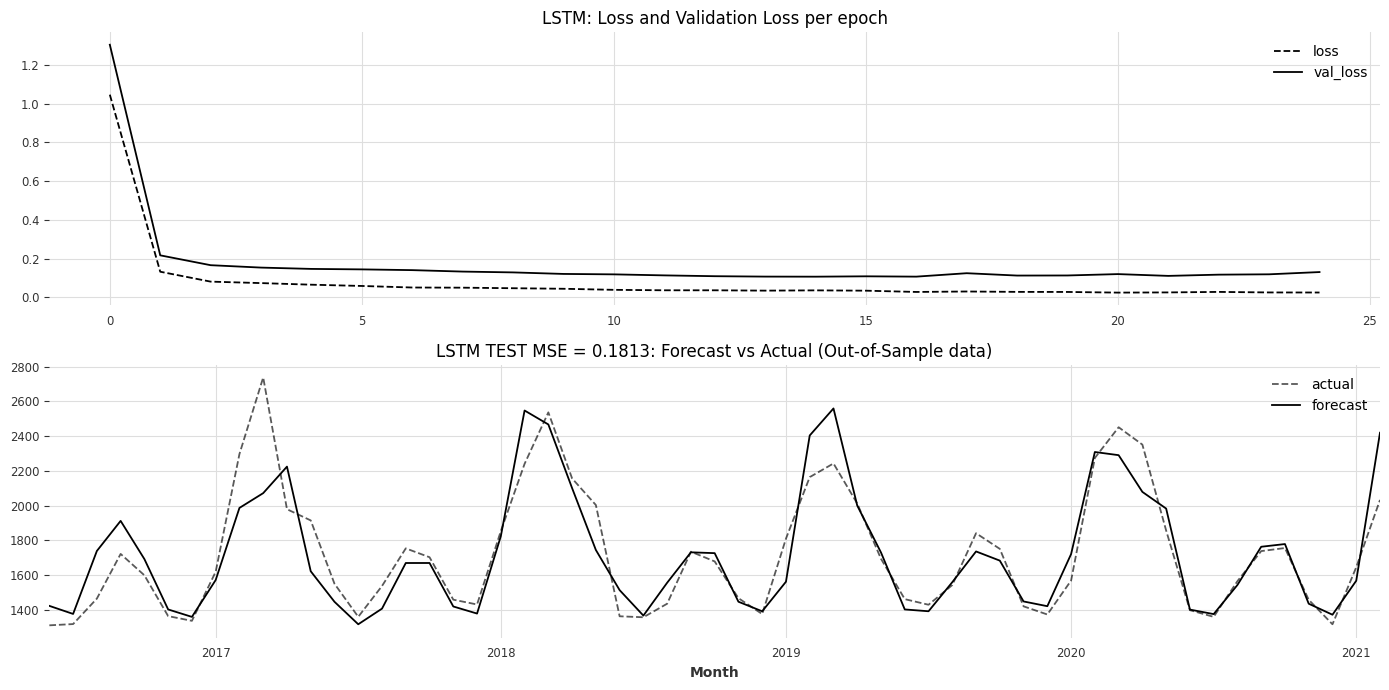

In [29]:
params_en = {'input_size':x_train_en.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}



en_lstm, history_en_lstm = train_model_pt('LSTM', **params_en)

In [30]:
# LSTM wiht dropout
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden


0/500 - Loss:  1.0624583959579468, val_loss: 1.393738865852356
20/500 - Loss:  0.11931142210960388, val_loss: 0.2477654665708542
40/500 - Loss:  0.07596288621425629, val_loss: 0.19674576818943024
60/500 - Loss:  0.06772903352975845, val_loss: 0.17202557623386383
80/500 - Loss:  0.06431929767131805, val_loss: 0.15689870715141296
100/500 - Loss:  0.057318903505802155, val_loss: 0.14304307103157043
120/500 - Loss:  0.05084680765867233, val_loss: 0.1378629207611084
140/500 - Loss:  0.04836730286478996, val_loss: 0.12998269498348236
160/500 - Loss:  0.049023110419511795, val_loss: 0.1329939365386963
180/500 - Loss:  0.04381628707051277, val_loss: 0.1297486126422882
200/500 - Loss:  0.0495910570025444, val_loss: 0.12220869958400726
220/500 - Loss:  0.040019042789936066, val_loss: 0.12684103846549988
240/500 - Loss:  0.04377767816185951, val_loss: 0.12536446750164032
260/500 - Loss:  0.03580768033862114, val_loss: 0.12903262674808502
280/500 - Loss:  0.03707602620124817, val_loss: 0.134703427

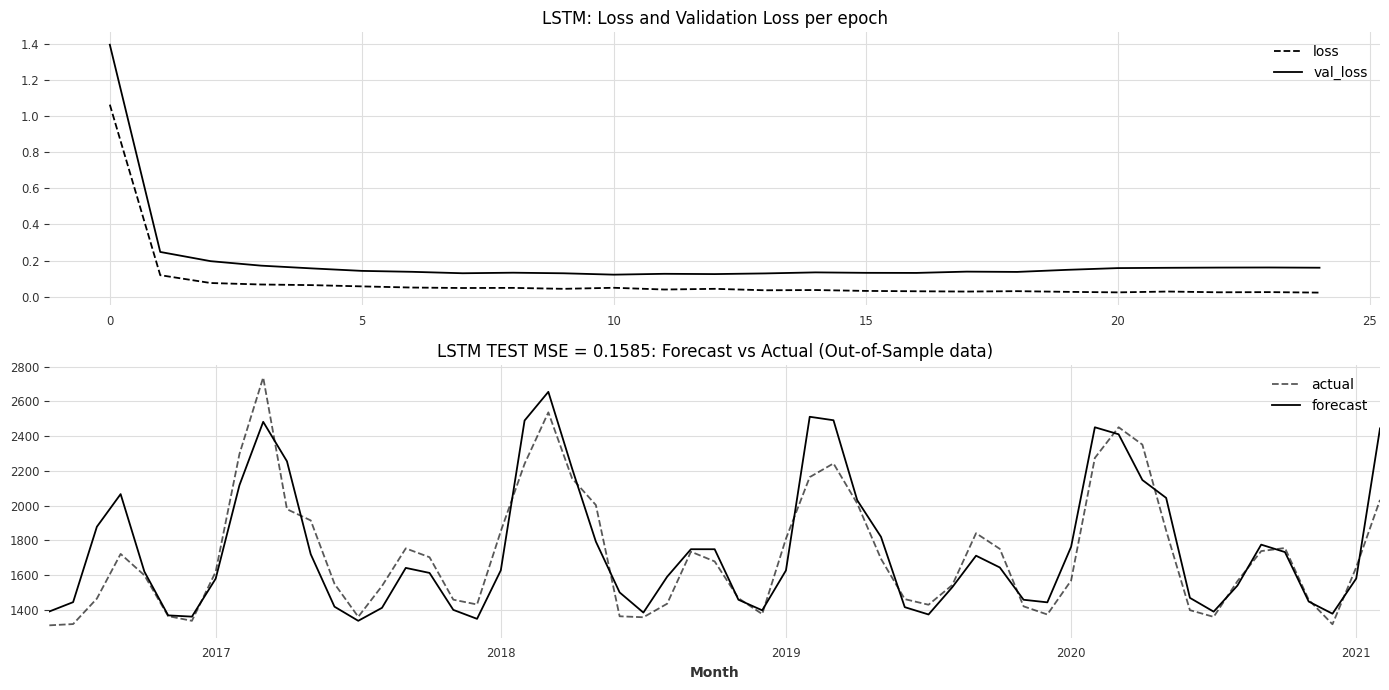

In [31]:
en_lstm_d, history_en_lstm_d = train_model_pt('LSTM', **params_en)

## Darts LSTM

In [33]:
# Issue where darts and u8darts were not same version. Just upgrade to ensure they are the same vesrion
#!pip install -U u8darts -q

In [41]:
!conda list dart

# packages in environment at /opt/anaconda3/envs/deep:
#
# Name                    Version                   Build  Channel
darts                     0.35.0                   pypi_0    pypi
u8darts                   0.35.0                   pypi_0    pypi


In [260]:
import darts
darts.__version__

'0.35.0'

In [262]:
from darts.models import RNNModel
from darts import TimeSeries

In [264]:
en_cp.reset_index()

,Month,y
0,1973-01-01,1957.640991
1,1973-02-01,1712.142944
2,1973-03-01,1510.078979
3,1973-04-01,1183.421021
4,1973-05-01,1006.325989
...,...,...
583,2021-08-01,1755.212036
584,2021-09-01,1456.901001
585,2021-10-01,1315.798950
586,2021-11-01,1644.306030


In [266]:
# limitations for MacBook M1
en_cp['y'] = en_cp['y'].astype('float32')
ts = TimeSeries.from_dataframe(en_cp.reset_index(), 
                               time_col='Month', 
                               value_cols='y', 
                               freq='MS')

val_split_point = int(len(ts) * 0.85) # Use first 85% for training
train, val = ts[:val_split_point], ts[val_split_point:]

from sklearn.preprocessing import StandardScaler
scaler = Scaler(StandardScaler())

# Fit scaler ONLY on training data and transform both
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(ts)

In [268]:
#train, val = ts.split_before(0.8)

In [270]:
INPUT_CHUNK_LENGTH = 10 # How many time steps the model sees (your 'window')
OUTPUT_CHUNK_LENGTH = 1  # How many steps the model predicts forward at a time
N_EPOCHS = 500           # Max number of epochs
HIDDEN_DIM = 32          # LSTM units
N_RNN_LAYERS = 1         # Number of LSTM layers
DROPOUT = 0.2            # Dropout rate
BATCH_SIZE = 32          # Batch size for training

model = RNNModel(
    model='LSTM',               # Specify the RNN type
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    hidden_dim=HIDDEN_DIM,     # Note: darts uses hidden_size
    n_rnn_layers=N_RNN_LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    optimizer_kwargs={'lr': 1e-3}, # Adam is default, set learning rate
    model_name='energy_lstm',
    log_tensorboard=False,       # Set True to use TensorBoard
    random_state=42,            # For reproducibility
    force_reset=True,           # Ensure fresh model training
    save_checkpoints=False,      # Set True to save model checkpoints
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [272]:
model.fit(train_scaled, val_series=val_scaled, verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=500` reached.


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=1, dropout=0.2, training_length=24, input_chunk_length=10, output_chunk_length=1, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=energy_lstm, log_tensorboard=False, random_state=42, force_reset=True, save_checkpoints=False)

In [274]:
forecast = model.predict(len(val))
forecast = scaler.inverse_transform(forecast)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [276]:
from darts.metrics import mape

error = mape(val, forecast)
print(f"MAPE: {error:.2f}%")

MAPE: 6.17%


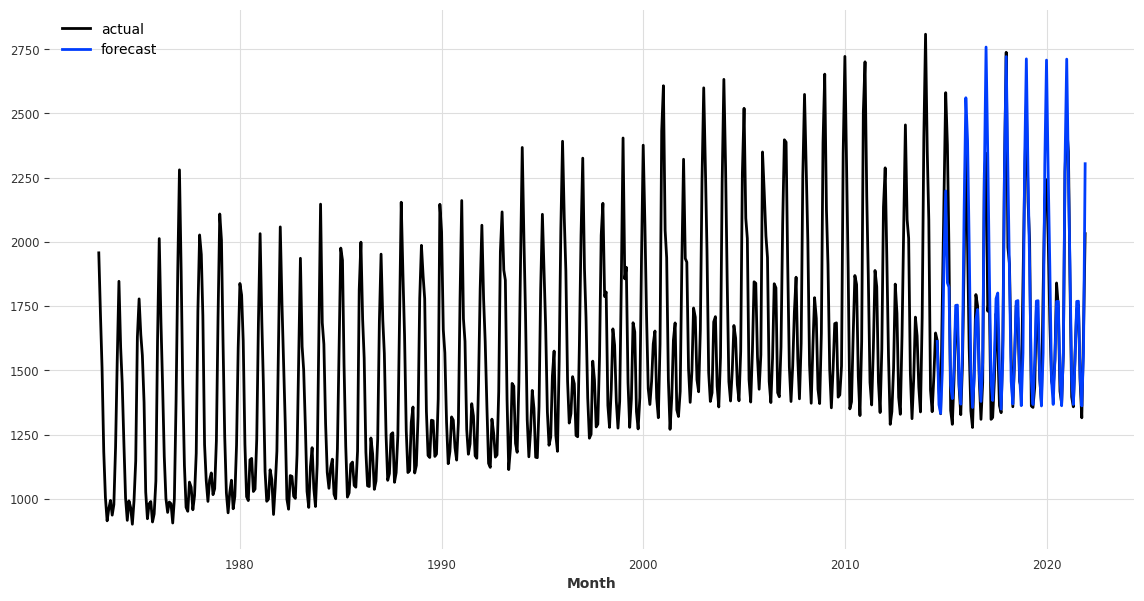

In [278]:
import matplotlib.pyplot as plt

ts.plot(label='actual')
forecast.plot(label='forecast')
plt.legend()
plt.show()

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Starting model training...


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.981


Validation: |                                                                                                 …

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.947


Validation: |                                                                                                 …

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.881


Validation: |                                                                                                 …

Metric val_loss improved by 0.089 >= min_delta = 0.001. New best score: 0.793


Validation: |                                                                                                 …

Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 0.739


Validation: |                                                                                                 …

Metric val_loss improved by 0.084 >= min_delta = 0.001. New best score: 0.655


Validation: |                                                                                                 …

Metric val_loss improved by 0.083 >= min_delta = 0.001. New best score: 0.572


Validation: |                                                                                                 …

Metric val_loss improved by 0.064 >= min_delta = 0.001. New best score: 0.508


Validation: |                                                                                                 …

Metric val_loss improved by 0.054 >= min_delta = 0.001. New best score: 0.453


Validation: |                                                                                                 …

Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.411


Validation: |                                                                                                 …

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.372


Validation: |                                                                                                 …

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.338


Validation: |                                                                                                 …

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.306


Validation: |                                                                                                 …

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.274


Validation: |                                                                                                 …

Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 0.244


Validation: |                                                                                                 …

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.222


Validation: |                                                                                                 …

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.210


Validation: |                                                                                                 …

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.199


Validation: |                                                                                                 …

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.192


Validation: |                                                                                                 …

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.185


Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.182


Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.179


Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.177


Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.174


Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.173


Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.170


Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.168


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.166


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.165


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.164


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.161


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.159


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.158


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.157


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.155


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.153


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.150


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.149


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Monitored metric val_loss did not improve in the last 12 records. Best score: 0.149. Signaling Trainer to stop.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Generating predictions...


Predicting: |                                                                                                 …

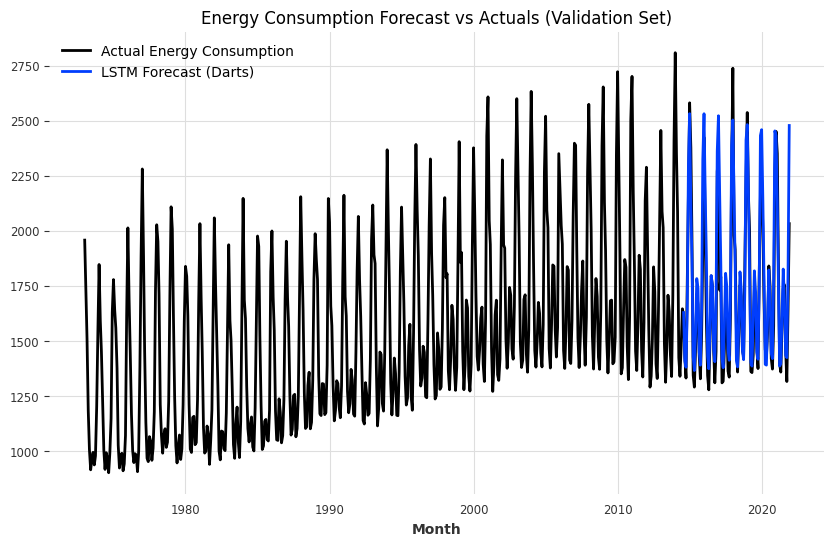

Validation RMSE: 135.8204
Validation MAE:  101.6598


In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

# Darts specific imports
from darts import TimeSeries
from darts.models import RNNModel  # Using RNNModel with model='LSTM'
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import rmse, mae

# PyTorch Lightning for trainer control (optional but common)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# --- 1. Data Loading and Initial Preparation ---
path = Path('../../datasets/Ch13/')
energy_df = pd.read_csv(path.joinpath('energy_consumption.csv'),
                        index_col='Month',
                        parse_dates=True)
energy_df.columns = ['y']
energy_df['y'] = energy_df['y'].astype('float32')
energy_df.index.freq = 'MS' # Ensure frequency is set

# Handle missing data (if any) - Same as before
n_missing = int(energy_df.isna().sum().sum())
if n_missing > 0:
    print(f'Found {n_missing} missing observations... filling forward.')
    energy_df.ffill(inplace=True)

# Convert Pandas Series/DataFrame to Darts TimeSeries
# Darts works best if the series has a unique name
series = TimeSeries.from_series(energy_df['y'], freq='MS')

# --- 2. Splitting Data ---
# Define split point (e.g., last 15% for validation/test)
# Let's do Train / Validation split first for model training
val_split_point = int(len(series) * 0.85) # Use first 85% for training
train, val = series[:val_split_point], series[val_split_point:]

# (Optional: Further split val into val and test if needed for final evaluation)
# test_split_point = int(len(val) * 0.5)
# val, test = val[:test_split_point], val[test_split_point:]


# --- 3. Scaling ---
# Use Darts Scaler (defaults to MinMaxScaler, use StandardScaler for consistency)
# You can choose different scalers from sklearn via darts wrapper
from sklearn.preprocessing import StandardScaler
scaler = Scaler(StandardScaler())

# Fit scaler ONLY on training data and transform both
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series) # Scale the whole series if needed later

# --- 4. Define and Train the Darts RNNModel (LSTM) ---

# Define parameters matching your previous setup where possible
INPUT_CHUNK_LENGTH = 10 # How many time steps the model sees (your 'window')
OUTPUT_CHUNK_LENGTH = 1  # How many steps the model predicts forward at a time
N_EPOCHS = 500           # Max number of epochs
HIDDEN_DIM = 32          # LSTM units
N_RNN_LAYERS = 1         # Number of LSTM layers
DROPOUT = 0.2            # Dropout rate
BATCH_SIZE = 32          # Batch size for training
PATIENCE = 12            # Early stopping patience

# Define PyTorch Lightning callbacks (e.g., Early Stopping)
# The logs_key='val_loss' assumes the validation loss is logged with this key
# Darts models using PyTorch Lightning often log validation loss automatically
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True
)

# Add callbacks to pl_trainer_kwargs
# You can add other Pytorch Lightning Trainer args here (e.g., accelerator='gpu')
trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True # Show training progress bar
    # Add "accelerator": "gpu", "devices": 1 if using GPU
}

# Create the RNNModel instance - specify 'LSTM'
# Make sure torch is installed: pip install torch
# Make sure pytorch-lightning is installed: pip install pytorch-lightning
model_en_lstm_darts = RNNModel(
    model='LSTM',               # Specify the RNN type
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    hidden_dim=HIDDEN_DIM,     # Note: darts uses hidden_size
    n_rnn_layers=N_RNN_LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    optimizer_kwargs={'lr': 1e-3}, # Adam is default, set learning rate
    model_name='energy_lstm',
    log_tensorboard=False,       # Set True to use TensorBoard
    random_state=42,            # For reproducibility
    force_reset=True,           # Ensure fresh model training
    save_checkpoints=False,      # Set True to save model checkpoints
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

print("Starting model training...")
# Train the model using the scaled training data
# Provide val_scaled for validation loss calculation and early stopping
model_en_lstm_darts.fit(train_scaled,
                        val_series=val_scaled,
                        verbose=True) # verbose=True shows epoch progress

# --- 5. Forecasting ---
print("Generating predictions...")
# Predict on the validation set timeframe
# n = number of steps to predict (length of validation set)
# The model automatically uses the end of the training series as input
preds_scaled = model_en_lstm_darts.predict(n=len(val))

# Inverse transform the predictions to the original scale
preds_energy = scaler.inverse_transform(preds_scaled)

# --- 6. Plotting and Evaluation ---
plt.figure(figsize=(10, 6))
series.plot(label='Actual Energy Consumption') # Plot full historical data
preds_energy.plot(label='LSTM Forecast (Darts)')
plt.title('Energy Consumption Forecast vs Actuals (Validation Set)')
plt.legend()
plt.show()

# Evaluate the forecast (on the validation set)
rmse_val = rmse(val, preds_energy)
mae_val = mae(val, preds_energy)
print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE:  {mae_val:.4f}")

# (Optional) You could retrain on train+val and predict on a final test set
# test_scaled = scaler.transform(test)
# model.fit(scaler.transform(train+val)) # Fit on combined data
# test_preds_scaled = model.predict(n=len(test))
# test_preds = scaler.inverse_transform(test_preds_scaled)
# rmse_test = rmse(test, test_preds) # Evaluate on test set

In [254]:
from darts.metrics import mape

error = mape(val, preds_energy)
print(f"MAPE: {error:.2f}%")

MAPE: 5.77%
